<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://goo.gl/rvvZiR).**

In [102]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

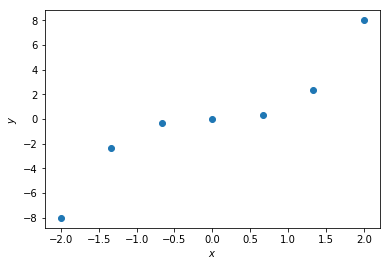

In [2]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график.

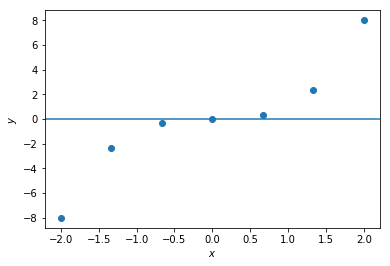

In [5]:
plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.axhline(y=0, xmin=-2, xmax=2);

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

In [73]:
print(y)

[-8.         -2.37037037 -0.2962963   0.          0.2962963   2.37037037
  8.        ]


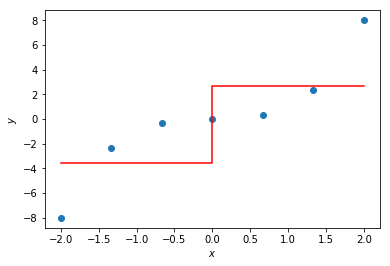

In [74]:
plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.plot([-2, 0, 0, 2], [-3.556, -3.556, 2.667, 2.667], 'r-');

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [44]:
def regression_var_criterion(X, y, t):
    i = 0
    while X[i] < t:
        i += 1
    Dx = np.std(y)
    Dl = np.std(y[:i])
    Dr = np.std(y[i:])
    n = len(X)
    Q = Dx - i / n * Dl - (n - i) / n * Dr
    return Q

In [45]:
QX = np.arange(-1.9, 2, 0.1)

In [46]:
QY = list(map(lambda x: regression_var_criterion(X, y, x), QX))

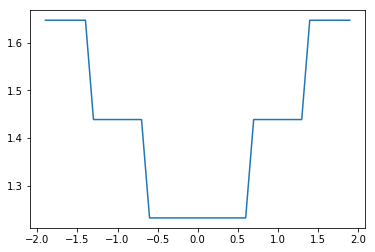

In [47]:
plt.plot(QX, QY);

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

In [60]:
print(X)

[-2.         -1.33333333 -0.66666667  0.          0.66666667  1.33333333
  2.        ]


In [66]:
q2y0 = y[0]
q2y1 = np.std(y[1:3])
q2y3 = np.std(y[3:6])
q2y4 = y[6]

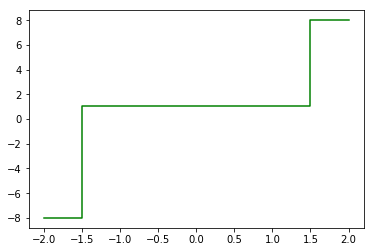

In [68]:
plt.figure()
plt.plot([X[0], -1.5, -1.5, 0, 0, 1.5, 1.5, X[6]], [q2y0, q2y0, q2y1, q2y1, q2y3, q2y3, q2y4, q2y4], 'g');

In [69]:
q2y1

1.0370370370370372

In [70]:
q2y3

1.054526247114203

**<font color='red'>Вопрос 2.</font> Из скольки отрезков состоит график, изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [87]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [88]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах", а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`.

In [90]:
df['age_years'] = df['age'].apply(lambda days: days / 365.25)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
id,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.357290
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.381246
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51.627652
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.249144
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47.841205


In [91]:
df = pd.get_dummies(df, columns=['cholesterol', 'gluc'])
df.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,age_years,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,0,0,1,0,50.357290,1,0,0,1,0,0
1,20228,1,156,85.0,140,90,0,0,1,1,55.381246,0,0,1,1,0,0
2,18857,1,165,64.0,130,70,0,0,0,1,51.627652,0,0,1,1,0,0
3,17623,2,169,82.0,150,100,0,0,1,1,48.249144,1,0,0,1,0,0
4,17474,1,156,56.0,100,60,0,0,0,0,47.841205,1,0,0,1,0,0


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(df.drop('cardio', 1), df['cardio'], train_size=7/10, random_state=17)

In [101]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((49000, 16), (21000, 16), (49000,), (21000,))

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [115]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)

In [117]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')

In [138]:
export_graphviz(tree,
                feature_names=X_train.columns,
                out_file='../../img/hw3_tree.dot',
                filled=True)

In [ ]:
#http://www.webgraphviz.com/

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [140]:
y_pred = tree.predict(X_valid)

In [141]:
accuracy_score(y_valid, y_pred)

0.72128571428571431

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [143]:
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(tree, tree_params, cv=5)

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

In [147]:
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [148]:
tree_grid.cv_results_

{'mean_fit_time': array([ 0.03520432,  0.04843178,  0.06116157,  0.07278609,  0.08533325,
         0.09862971,  0.11406136,  0.12624812,  0.13884902]),
 'mean_score_time': array([ 0.00194798,  0.00192614,  0.00185871,  0.00204139,  0.00224481,
         0.00226951,  0.0022346 ,  0.00264344,  0.0022943 ]),
 'mean_test_score': array([ 0.7155102 ,  0.72771429,  0.7304898 ,  0.73095918,  0.73195918,
         0.73034694,  0.72955102,  0.72808163,  0.72602041]),
 'mean_train_score': array([ 0.71551022,  0.7277143 ,  0.7307194 ,  0.73351022,  0.73529084,
         0.73989288,  0.7449337 ,  0.75084186,  0.75804593]),
 'param_max_depth': masked_array(data = [2 3 4 5 6 7 8 9 10],
              mask = [False False False False False False False False False],
        fill_value = ?),
 'params': ({'max_depth': 2},
  {'max_depth': 3},
  {'max_depth': 4},
  {'max_depth': 5},
  {'max_depth': 6},
  {'max_depth': 7},
  {'max_depth': 8},
  {'max_depth': 9},
  {'max_depth': 10}),
 'rank_test_score': array([9

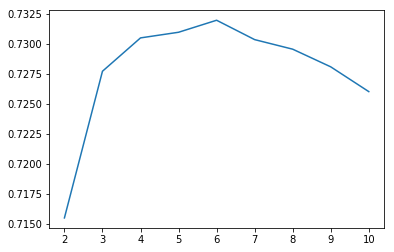

In [152]:
plt.plot(tree_params['max_depth'], tree_grid.cv_results_['mean_test_score'])

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [154]:
tree6 = DecisionTreeClassifier(max_depth=6, random_state=17)
tree6.fit(X_train, y_train)
accuracy_score(y_valid, tree6.predict(X_valid))

0.72580952380952379

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева четкий пик, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке?**
- да, да
- да, нет
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках.

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [155]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,age_years,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,0,0,1,0,50.357290,1,0,0,1,0,0
1,20228,1,156,85.0,140,90,0,0,1,1,55.381246,0,0,1,1,0,0
2,18857,1,165,64.0,130,70,0,0,0,1,51.627652,0,0,1,1,0,0
3,17623,2,169,82.0,150,100,0,0,1,1,48.249144,1,0,0,1,0,0
4,17474,1,156,56.0,100,60,0,0,0,0,47.841205,1,0,0,1,0,0


In [165]:
binar = df.drop(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'age_years', 'alco', 'active', 'gluc_1', 'gluc_2', 'gluc_3'], 1)
binar.head()

,smoke,cardio,cholesterol_1,cholesterol_2,cholesterol_3
id,,,,,
0,0,0,1,0,0
1,0,1,0,0,1
2,0,1,0,0,1
3,0,1,1,0,0
4,0,0,1,0,0


In [166]:
binar['age_45_50'] = df.apply(lambda row: row['age_years'] >= 45 and row['age_years'] < 50, axis = 1).astype(int)
binar['age_50_55'] = df.apply(lambda row: row['age_years'] >= 50 and row['age_years'] < 55, axis = 1).astype(int)
binar['age_55_60'] = df.apply(lambda row: row['age_years'] >= 55 and row['age_years'] < 60, axis = 1).astype(int)
binar['age_60_65'] = df.apply(lambda row: row['age_years'] >= 60 and row['age_years'] < 65, axis = 1).astype(int)
binar.head()

,smoke,cardio,cholesterol_1,cholesterol_2,cholesterol_3,age_45_50,age_50_55,age_55_60,age_60_65
id,,,,,,,,,
0,0,0,1,0,0,0,1,0,0
1,0,1,0,0,1,0,0,1,0
2,0,1,0,0,1,0,1,0,0
3,0,1,1,0,0,1,0,0,0
4,0,0,1,0,0,1,0,0,0


In [167]:
binar['aphi_120_140'] = df.apply(lambda row: row['ap_hi'] >= 120 and row['ap_hi'] < 140, axis = 1).astype(int)
binar['aphi_140_160'] = df.apply(lambda row: row['ap_hi'] >= 140 and row['ap_hi'] < 160, axis = 1).astype(int)
binar['aphi_160_180'] = df.apply(lambda row: row['ap_hi'] >= 160 and row['ap_hi'] < 180, axis = 1).astype(int)
binar.head()

,smoke,cardio,cholesterol_1,cholesterol_2,cholesterol_3,age_45_50,age_50_55,age_55_60,age_60_65,aphi_120_140,aphi_140_160,aphi_160_180
id,,,,,,,,,,,,
0,0,0,1,0,0,0,1,0,0,0,0,0
1,0,1,0,0,1,0,0,1,0,0,1,0
2,0,1,0,0,1,0,1,0,0,1,0,0
3,0,1,1,0,0,1,0,0,0,0,1,0
4,0,0,1,0,0,1,0,0,0,0,0,0


In [169]:
binar['male'] = df.apply(lambda row: row['gender'] - 1, axis = 1).astype(int)
binar.head()

,smoke,cardio,cholesterol_1,cholesterol_2,cholesterol_3,age_45_50,age_50_55,age_55_60,age_60_65,aphi_120_140,aphi_140_160,aphi_160_180,male
id,,,,,,,,,,,,,
0,0,0,1,0,0,0,1,0,0,0,0,0,1
1,0,1,0,0,1,0,0,1,0,0,1,0,0
2,0,1,0,0,1,0,1,0,0,1,0,0,0
3,0,1,1,0,0,1,0,0,0,0,1,0,1
4,0,0,1,0,0,1,0,0,0,0,0,0,0


In [177]:
second_tree = DecisionTreeClassifier(max_depth=3, random_state=17)

In [178]:
binarX = binar.drop('cardio', 1)

In [179]:
binarY = binar['cardio']

In [180]:
second_tree.fit(binarX, binarY)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')

In [181]:
export_graphviz(second_tree,
                feature_names=binarX.columns,
                out_file='../../img/hw3_second_tree.dot',
                filled=True)

In [ ]:
#http://www.webgraphviz.com/